# KNN - with Smote Balanced MinMaxScaler Data

Use different parameter settings and optimize number of neighbors for each setting.

### Load Packages

In [1]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as tkr
import seaborn as sn
from datetime import datetime as dt
from pprint import pprint
import itertools

from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.tree import plot_tree

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_curve, auc

### Load data

In [2]:
X_train, X_test, y_train, y_test = pickle.load( open( "../../pickles/intercorr_app2_MinMaxScaler_smote_20210711_214137.pickle", "rb" ) )

### Define Scoring functions for cross_validation

In [3]:
scoring = {'accuracy': 'accuracy',
           'bal_acc' : 'balanced_accuracy',
           'f1' : 'f1',
           'recall': 'recall',
           'precision' : 'precision',
           'roc_auc' : 'roc_auc',
           'specificity' : make_scorer(recall_score, pos_label=0),
           }

In [4]:
def average_score_on_cross_val_classification(clf, X, y, scoring=scoring, cv=StratifiedShuffleSplit(10)):
    # Score metrics on cross-validated dataset
    scores_dict = cross_validate(clf, X, y, scoring=scoring, cv=cv, n_jobs=-1)

    # return the average scores for each metric
    return {metric: round(np.mean(scores), 5) for metric, scores in scores_dict.items()}

### Evaluate with Test Data

Functions to evaluate against external data using different scoring metrices.

In [5]:
# Calculates the test score values for each score.
def calc_test_scores(y_test, y_predicted):
    test_scores = {'Balanced Accuracy' : balanced_accuracy_score(y_test, y_predicted),
                   'Accuracy': accuracy_score(y_test, y_predicted),
                   'ROC_AUC': roc_auc_score(y_test, y_predicted),
                   'f1_score': f1_score(y_test, y_predicted),
                   'recall_score' : recall_score(y_test, y_predicted),
                   'specificity_score' : recall_score(y_test, y_predicted, pos_label=0),
                   'precision_score' : precision_score(y_test, y_predicted),
    }
    return test_scores

# Valdiation routine for external data.
def validate_against_test(obj, X_test, y_test):
    y_predicted = obj.predict(X_test)
    error = np.mean(y_predicted != y_test)
    cm = confusion_matrix(y_test, y_predicted)
    scores = calc_test_scores(y_test, y_predicted)
    return scores, cm, error

### Calculations
Run a pseudo-grid scan, with different KNN parameters (algoparams). All possible combinations will be tested and then individually cross-validated against several scores (given in dict scores). Finally, each combination is evaluated against external data.

In [6]:
values = np.arange(1,25,2)
algoparams = {'weights' : ['distance', 'uniform'],
             'algorithm' : ['ball_tree', 'kd_tree', 'brute']}
algocombs = list(itertools.product(algoparams['weights'], algoparams['algorithm']))

allres = []

for comb in algocombs:
    val_res = []
    for val in values:
        clf = KNeighborsClassifier(n_neighbors=val, weights=comb[0], algorithm=comb[1])
        cross_results = average_score_on_cross_val_classification(clf, X_train, y_train)
        clf = clf.fit(X_train, y_train)
        scores, confmatrix, error = validate_against_test(clf, X_test, y_test)
        val_res.append((cross_results, scores, confmatrix, error, comb))
    
    allres.append(val_res)

### Plot Results

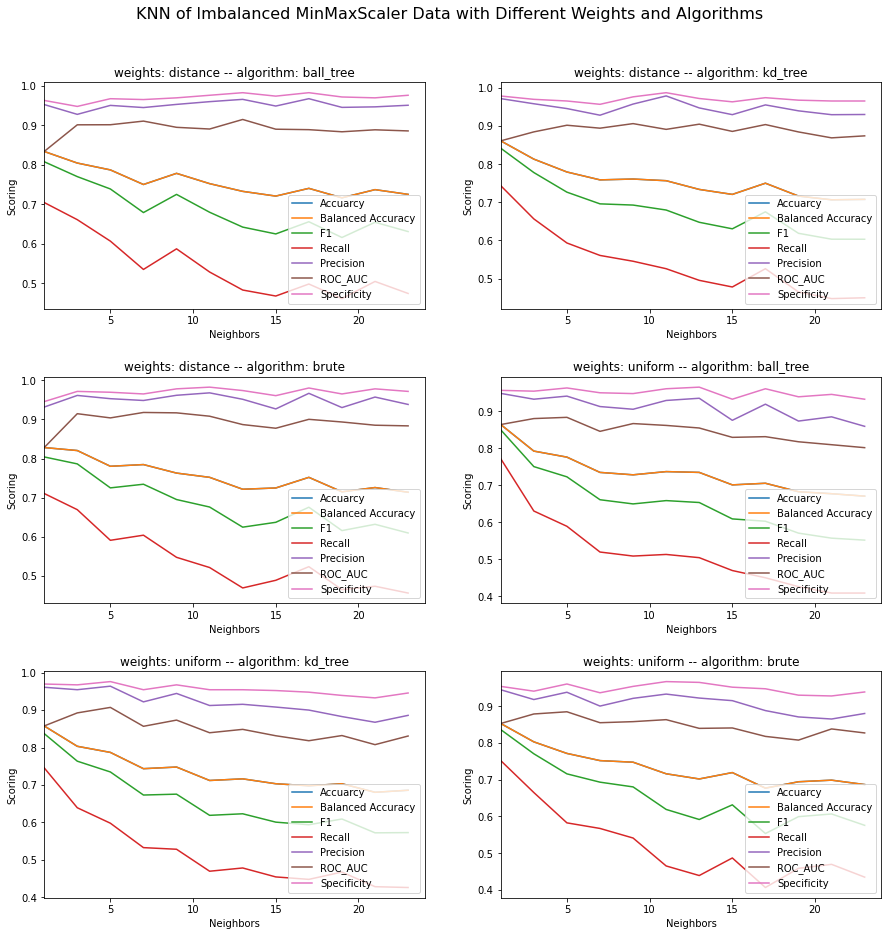

In [7]:
weights = values

fig, ax = plt.subplots(3,2 , figsize=(15,15))
ax = ax.flatten()

plt.subplots_adjust(hspace = 0.3)
fig.suptitle('KNN of Imbalanced MinMaxScaler Data with Different Weights and Algorithms', fontsize=16, y=0.95)
for ra in np.arange(0,6,1):
    ax[ra].plot(weights, [r[0]['test_accuracy'] for r in allres[ra]], label='Accuarcy')
    ax[ra].plot(weights, [r[0]['test_bal_acc'] for r in allres[ra]], label='Balanced Accuracy')
    ax[ra].plot(weights, [r[0]['test_f1'] for r in allres[ra]], label='F1')
    ax[ra].plot(weights, [r[0]['test_recall'] for r in allres[ra]], label='Recall')
    ax[ra].plot(weights, [r[0]['test_precision'] for r in allres[ra]], label='Precision')
    ax[ra].plot(weights, [r[0]['test_roc_auc'] for r in allres[ra]], label='ROC_AUC')
    ax[ra].plot(weights, [r[0]['test_specificity'] for r in allres[ra]], label='Specificity')
    ax[ra].legend(loc='lower right')
    ax[ra].set_xlabel('Neighbors')
    ax[ra].set_ylabel('Scoring')
    ax[ra].set_xlim([1,len(values)*2])
    ax[ra].set_title('weights: %s -- algorithm: %s' %(allres[ra][-1][-1][0], allres[ra][-1][-1][1]))


### Confusion Matrices
Plot confusion matrix for each parameter setting and k-value used above. In addition the scores are given below the confusion matrix.

In [8]:
def plottext(text):
    _text = []
    for k, v in text.items():
        _text.append('%s: %1.2f\n'%(k,v))
    
    return ''.join(_text)

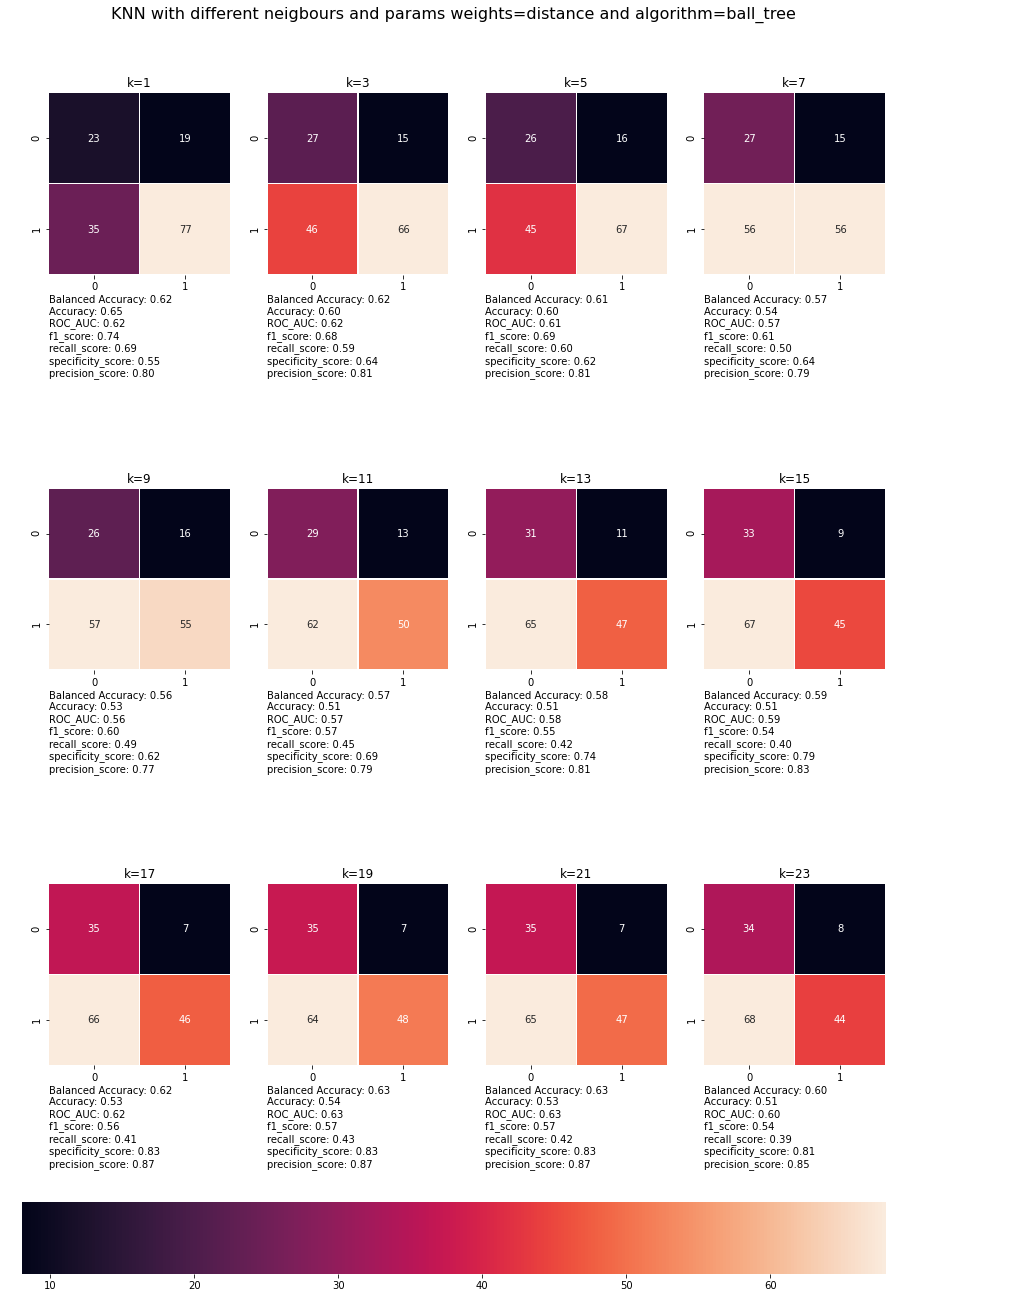

In [9]:
paramset = 0 # Which parameter set to plot.
weights = values

fig, ax = plt.subplots(3,4 , figsize=(15,20),)#sharex=True, sharey=True)
ax = ax.flatten()
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, .05])

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.04, wspace=None, hspace=-0.25)
fig.suptitle('KNN with different neigbours and params weights=%s and algorithm=%s' %(allres[paramset][-1][-1][0], allres[paramset][-1][-1][1]), fontsize=16, y=0.98)

for ra in np.arange(0,12,1):
    sn.heatmap(allres[paramset][ra][2], annot=True, ax=ax[ra], square=True, cbar_ax=cbar_ax, linewidths=.5, cbar_kws={"orientation": "horizontal"})
    ax[ra].set_title('k=%s'%(ra*2+1))
    ax[ra].text(0, 3.25, plottext(allres[0][ra][1]), ha='left')


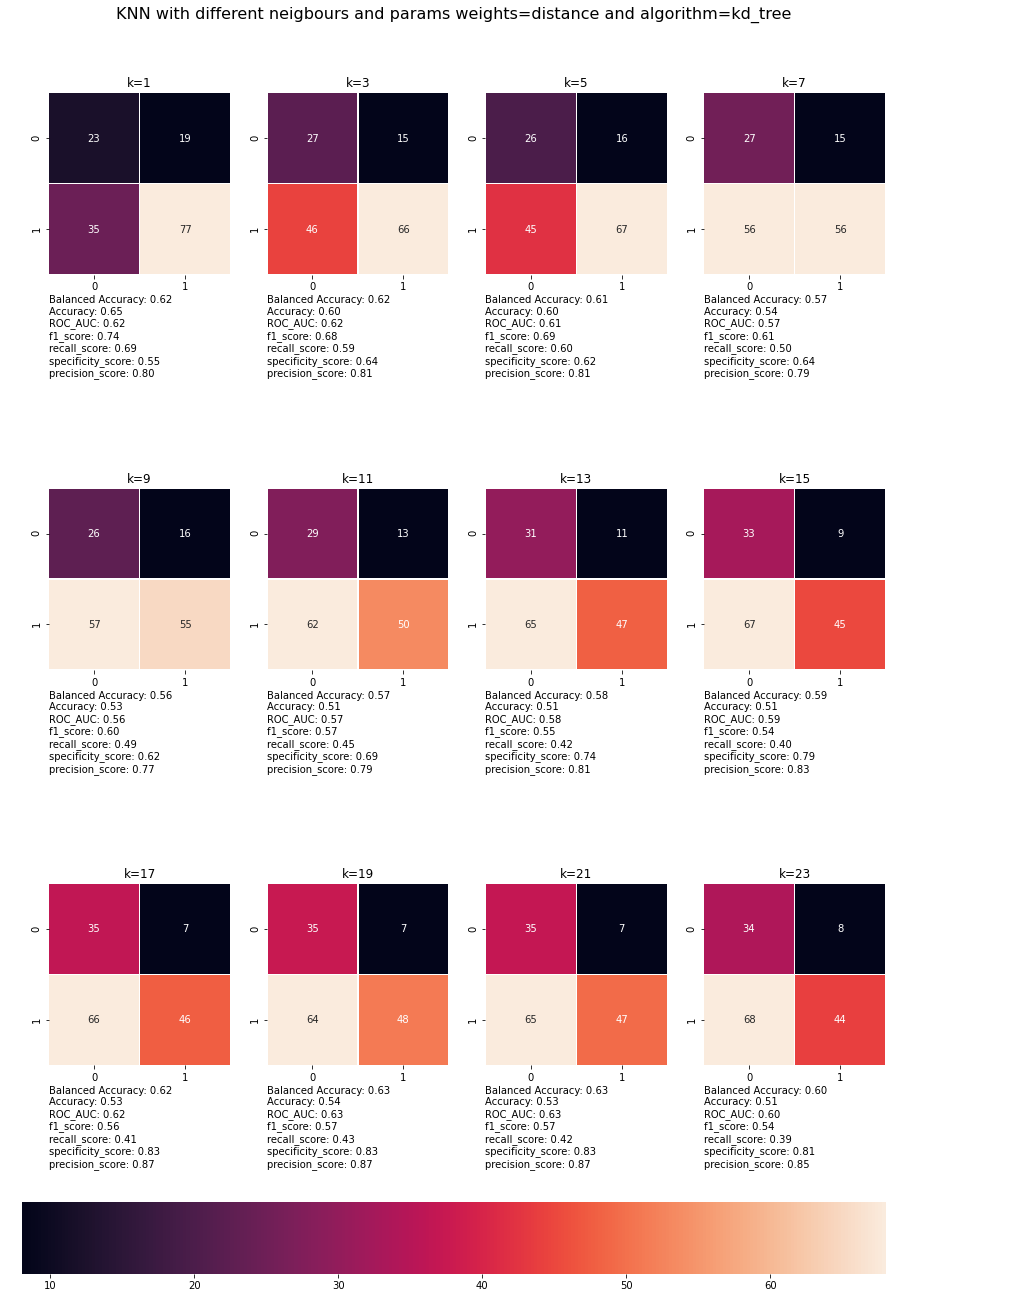

In [10]:
paramset = 1 # Which parameter set to plot.
weights = values

fig, ax = plt.subplots(3,4 , figsize=(15,20),)#sharex=True, sharey=True)
ax = ax.flatten()
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, .05])

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.04, wspace=None, hspace=-0.25)
fig.suptitle('KNN with different neigbours and params weights=%s and algorithm=%s' %(allres[paramset][-1][-1][0], allres[paramset][-1][-1][1]), fontsize=16, y=0.98)

for ra in np.arange(0,12,1):
    sn.heatmap(allres[paramset][ra][2], annot=True, ax=ax[ra], square=True, cbar_ax=cbar_ax, linewidths=.5, cbar_kws={"orientation": "horizontal"})
    ax[ra].set_title('k=%s'%(ra*2+1))
    ax[ra].text(0, 3.25, plottext(allres[0][ra][1]), ha='left')

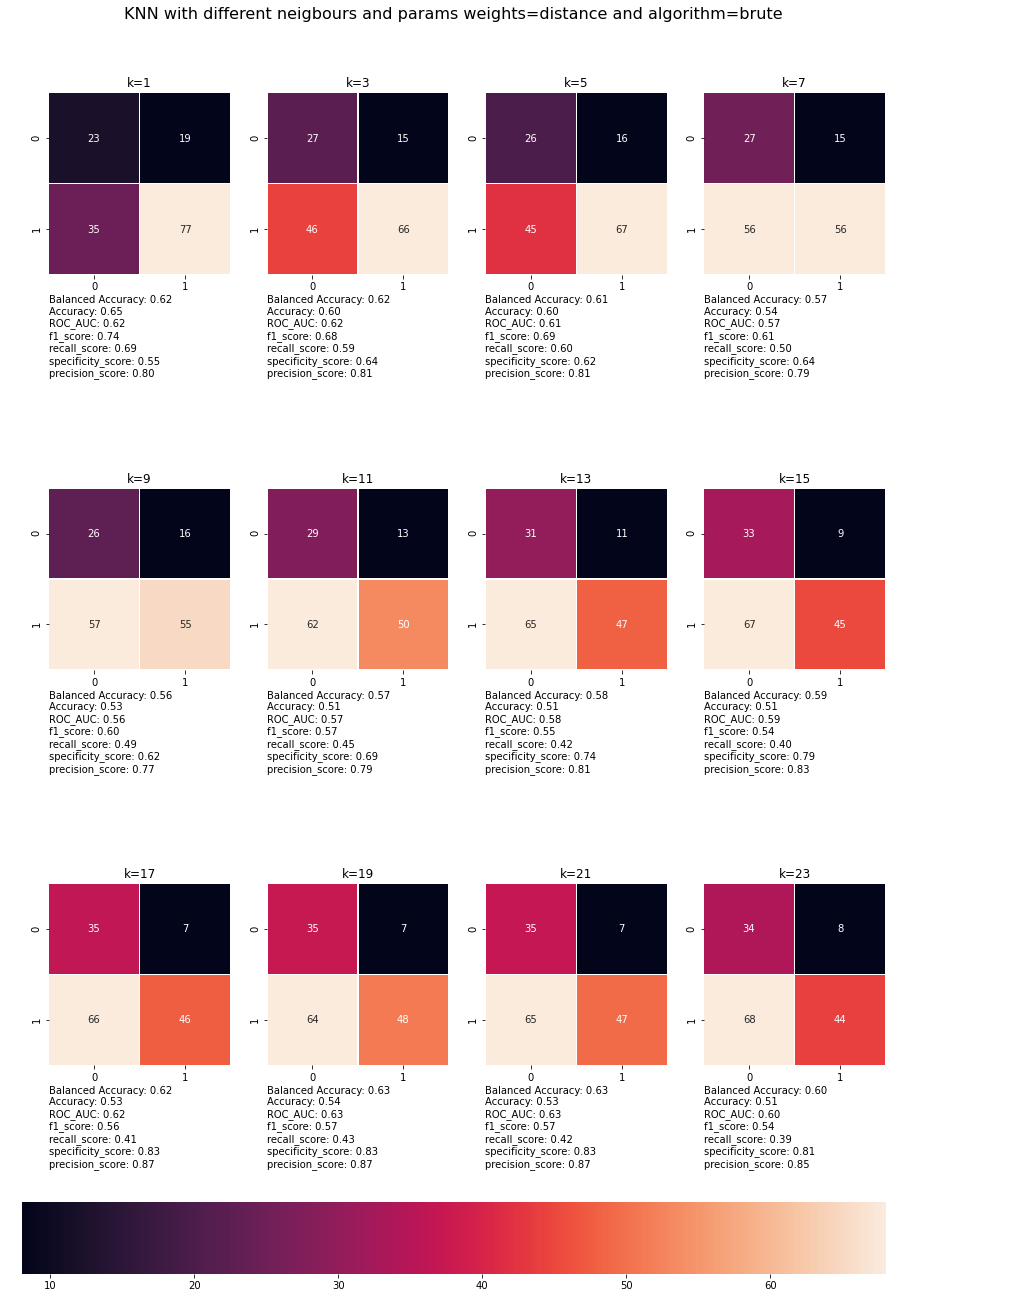

In [11]:
paramset = 2 # Which parameter set to plot.
weights = values

fig, ax = plt.subplots(3,4 , figsize=(15,20),)#sharex=True, sharey=True)
ax = ax.flatten()
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, .05])

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.04, wspace=None, hspace=-0.25)
fig.suptitle('KNN with different neigbours and params weights=%s and algorithm=%s' %(allres[paramset][-1][-1][0], allres[paramset][-1][-1][1]), fontsize=16, y=0.98)

for ra in np.arange(0,12,1):
    sn.heatmap(allres[paramset][ra][2], annot=True, ax=ax[ra], square=True, cbar_ax=cbar_ax, linewidths=.5, cbar_kws={"orientation": "horizontal"})
    ax[ra].set_title('k=%s'%(ra*2+1))
    ax[ra].text(0, 3.25, plottext(allres[0][ra][1]), ha='left')

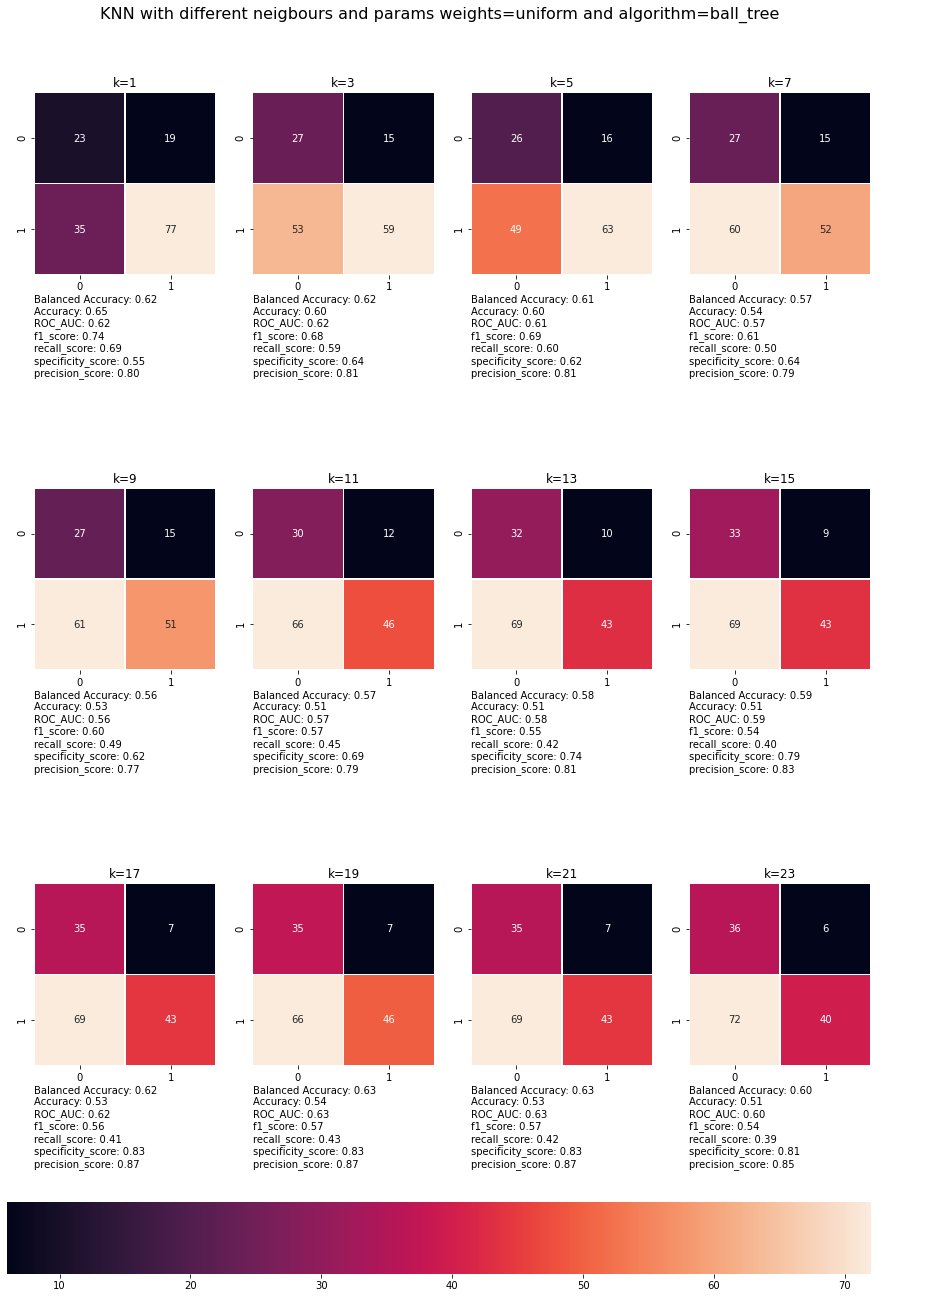

In [12]:
paramset = 3 # Which parameter set to plot.
weights = values

fig, ax = plt.subplots(3,4 , figsize=(15,20),)#sharex=True, sharey=True)
ax = ax.flatten()
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, .05])

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.04, wspace=None, hspace=-0.25)
fig.suptitle('KNN with different neigbours and params weights=%s and algorithm=%s' %(allres[paramset][-1][-1][0], allres[paramset][-1][-1][1]), fontsize=16, y=0.98)

for ra in np.arange(0,12,1):
    sn.heatmap(allres[paramset][ra][2], annot=True, ax=ax[ra], square=True, cbar_ax=cbar_ax, linewidths=.5, cbar_kws={"orientation": "horizontal"})
    ax[ra].set_title('k=%s'%(ra*2+1))
    ax[ra].text(0, 3.25, plottext(allres[0][ra][1]), ha='left')

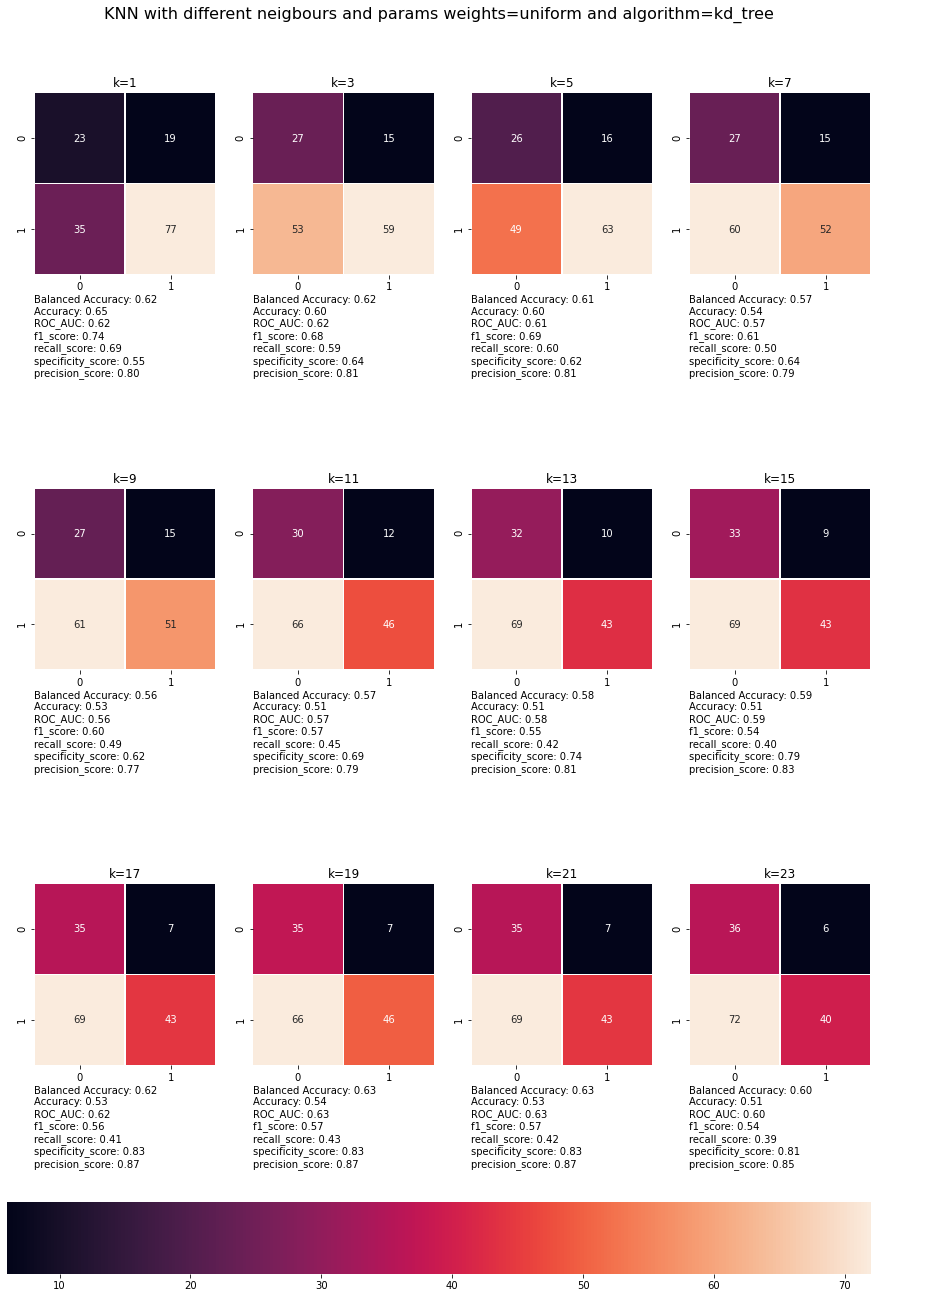

In [13]:
paramset = 4 # Which parameter set to plot.
weights = values

fig, ax = plt.subplots(3,4 , figsize=(15,20),)#sharex=True, sharey=True)
ax = ax.flatten()
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, .05])

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.04, wspace=None, hspace=-0.25)
fig.suptitle('KNN with different neigbours and params weights=%s and algorithm=%s' %(allres[paramset][-1][-1][0], allres[paramset][-1][-1][1]), fontsize=16, y=0.98)

for ra in np.arange(0,12,1):
    sn.heatmap(allres[paramset][ra][2], annot=True, ax=ax[ra], square=True, cbar_ax=cbar_ax, linewidths=.5, cbar_kws={"orientation": "horizontal"})
    ax[ra].set_title('k=%s'%(ra*2+1))
    ax[ra].text(0, 3.25, plottext(allres[0][ra][1]), ha='left')

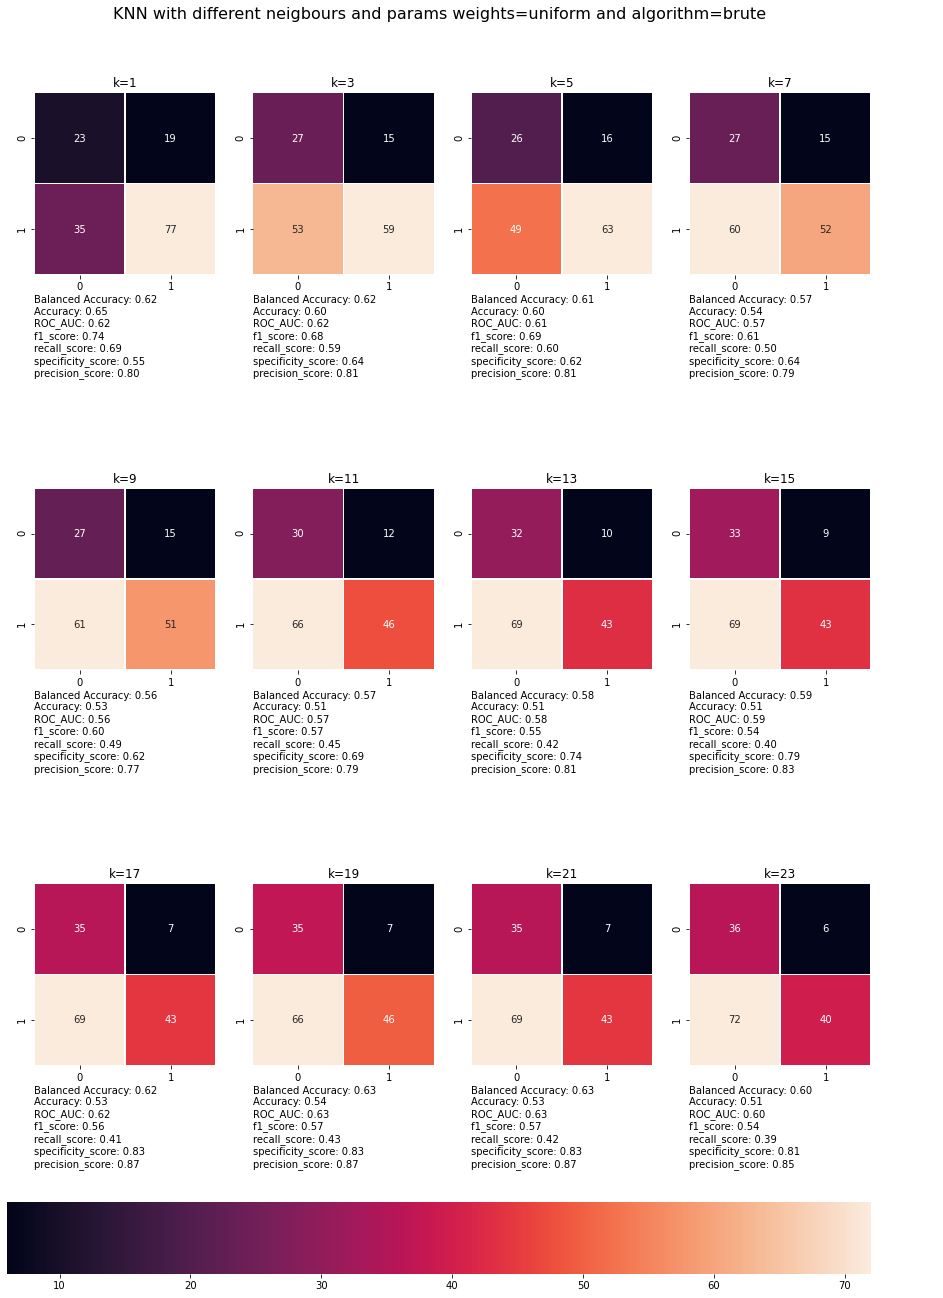

In [14]:
paramset = 5 # Which parameter set to plot.
weights = values

fig, ax = plt.subplots(3,4 , figsize=(15,20),)#sharex=True, sharey=True)
ax = ax.flatten()
cbar_ax = fig.add_axes([0.1, 0.1, 0.8, .05])

plt.subplots_adjust(left=None, bottom=None, right=None, top=1.04, wspace=None, hspace=-0.25)
fig.suptitle('KNN with different neigbours and params weights=%s and algorithm=%s' %(allres[paramset][-1][-1][0], allres[paramset][-1][-1][1]), fontsize=16, y=0.98)

for ra in np.arange(0,12,1):
    sn.heatmap(allres[paramset][ra][2], annot=True, ax=ax[ra], square=True, cbar_ax=cbar_ax, linewidths=.5, cbar_kws={"orientation": "horizontal"})
    ax[ra].set_title('k=%s'%(ra*2+1))
    ax[ra].text(0, 3.25, plottext(allres[0][ra][1]), ha='left')

### Simple Gridsearch with different parameters and CV against different scores

In [4]:
# Define grid and scoring
grid = {'weights' : ['distance', 'uniform'],
        'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
        'n_neighbors' : np.arange(1,15,2),
        }

scoring = {'f1' : 'f1',
           'recall': 'recall',
           #'precision' : 'precision',
           'specificity' : make_scorer(recall_score, pos_label=0),
           }

In [5]:
grid_results = {}

In [9]:
for sco, sc in scoring.items():
    clf = GridSearchCV(KNeighborsClassifier(), grid, cv=StratifiedKFold(20), scoring=sc, n_jobs=-1)
    clf.fit(X_train, y_train)
    grid_results[sco] = clf

#### Best estimator

In [10]:
for k,v in grid_results.items():
    print(k + '-score: %s\n'  %grid_results[k].best_estimator_)

f1-score: KNeighborsClassifier(algorithm='ball_tree', n_neighbors=1, weights='distance')

recall-score: KNeighborsClassifier(algorithm='ball_tree', n_neighbors=1, weights='distance')

specificity-score: KNeighborsClassifier(algorithm='ball_tree', weights='distance')



#### Representation of Results

Optimized for f1-score: -- Evaluation with Training Set 

Balanced Accuracy:  1.0
Accuracy :  1.0
f1-score :  1.0
Recall :  1.0
Specificity :  1.0
---------------

Optimized for f1-score: -- Confusion Matrix and External Evaluation 

Balanced Accuracy:  0.6175595238095238
Accuracy :  0.6493506493506493
f1-score:  0.7403846153846154
Recall :  0.6875
Specificity :  0.5476190476190477


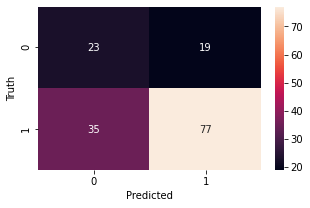




Optimized for recall-score: -- Evaluation with Training Set 

Balanced Accuracy:  1.0
Accuracy :  1.0
f1-score :  1.0
Recall :  1.0
Specificity :  1.0
---------------

Optimized for recall-score: -- Confusion Matrix and External Evaluation 

Balanced Accuracy:  0.6175595238095238
Accuracy :  0.6493506493506493
f1-score:  0.7403846153846154
Recall :  0.6875
Specificity :  0.5476190476190477


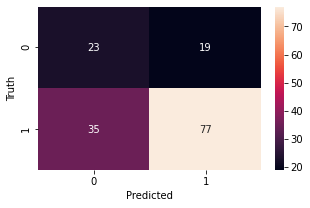




Optimized for specificity-score: -- Evaluation with Training Set 

Balanced Accuracy:  1.0
Accuracy :  1.0
f1-score :  1.0
Recall :  1.0
Specificity :  1.0
---------------

Optimized for specificity-score: -- Confusion Matrix and External Evaluation 

Balanced Accuracy:  0.6086309523809523
Accuracy :  0.6038961038961039
f1-score:  0.6871794871794872
Recall :  0.5982142857142857
Specificity :  0.6190476190476191


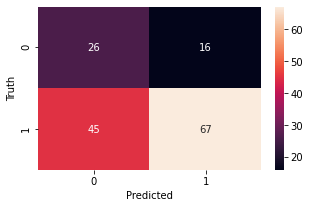

In [14]:
for k,v in grid_results.items():

    print('============================================================================')
    print('Optimized for %s-score: -- Evaluation with Training Set \n' %(k))
    y_predicted = grid_results[k].predict(X_train)
    print('Balanced Accuracy: ', balanced_accuracy_score(y_train, y_predicted))
    print('Accuracy : ', accuracy_score(y_train, y_predicted))
    print('f1-score : ', f1_score(y_train, y_predicted))
    print('Recall : ' , recall_score(y_train, y_predicted))
    print('Specificity : ', recall_score(y_train, y_predicted, pos_label=0) )
    print('---------------\n')
    print('Optimized for %s-score: -- Confusion Matrix and External Evaluation \n' %(k))
    #cm1 = confusion_matrix(y_train, y_predicted)
    y_predicted = grid_results[k].predict(X_test)
    cm1 = confusion_matrix(y_test, y_predicted)
    print('Balanced Accuracy: ', balanced_accuracy_score(y_test, y_predicted))
    print('Accuracy : ', accuracy_score(y_test, y_predicted))
    print('f1-score: ', f1_score(y_test, y_predicted))
    print('Recall : ' , recall_score(y_test, y_predicted))
    print('Specificity : ', recall_score(y_test, y_predicted, pos_label=0) )
    # Visualize it as a heatmap
    import matplotlib.pyplot as plt
    import seaborn as sn
    plt.figure(figsize=(5,3))
    sn.heatmap(cm1,annot=True, fmt='g')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    plt.show()
    print('\n\n')

### Save to pickle

In [21]:
out = (allres, grid_results)
timestamp = dt.now().strftime("%Y%m%d_%H%M%S")
filename = '../../pickles/KNN_MinMax_smote_%s.pickle' %timestamp
filehandler = open(filename, 'wb')
pickle.dump(out, filehandler)